**XGBoost**

This notebook contains the python code to construct a simple XGBoost Algorithm from scratch. The loss function chosen is the negative log-likelihood (Binary Cross Entropy) with the logit transformation on the predicted scores.

The dataset used here is an email spam dataset. This dataset has 57 continuous predictors and 1 nominal class label, {0, 1}.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D

Load the data and do the training and testing dataset split

In [3]:
# load data 
data = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header=None)
p_ = data.shape[1]
p = p_ - 1
X = data.iloc[:, :p]
y = data.iloc[:, p]

# split the data to training set and testing test
# the training set will be used to choose hyperparameters
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3680, 57) (921, 57) (3680,) (921,)


**XGB Function class**

In [0]:
# define a function or class to implement the xgboost
#########################################################

class XGBOOST():
    def __init__(self, min_impurity_decrease=0.01, M=5):
        self.min_impurity_decrease = min_impurity_decrease
        self.M = int(M)
        self.weak_classifer = []
        self.score = None
        self.score_t = None
        self.training_acc = []
        self.testing_acc = []
    
    def update_y(self,y,s):
        
        # Use the Negative Log-Lik Loss with logit transformation to score
        neg_first_order = y-1/(1+np.exp(-s))
        second_order = np.exp(-s)/((1+np.exp(-s))**2) + 0.01
        y_new = neg_first_order/second_order
        return y_new
    
    def score_to_label(self,score):
        
        # Transfer the score values to the classification labels
        train_pred = 1/(1+np.exp(-score))
        train_pred[train_pred<=0.5] = 0
        train_pred[train_pred>0.5] = 1
        return train_pred

    def training(self, train_features, train_labels):
        
        n = train_features.shape[0]
        self.score = np.zeros(n)
        y_new = train_labels
        
        for i in range(self.M):
            
            # Train the week classifier: a Tree model
            dt = DecisionTreeRegressor(min_impurity_decrease=self.min_impurity_decrease)
            dt.fit(train_features,y_new)
            self.weak_classifer.append(dt) # Store the trained week classifier
            
            # calculate and sum up the object score
            s = dt.predict(train_features)
            self.score =  self.score + s
            y_new = self.update_y(train_labels,self.score)
            
            # Calculate and store the trainig accuracy
            train_pred = self.score_to_label(self.score)
            acc = sum(train_pred==train_labels)/n
            self.training_acc.append(acc)
            
            # Print out the training process
            print('Adding Tree %d, the training accuracy is %f' %(i+1,acc))
            
        return acc

    def testing(self, test_features, test_labels):
        
        k = test_features.shape[0]
        self.score_t = np.zeros(k)
        
        for i,wc in enumerate(self.weak_classifer):
          
            # Caculate and sum up the object score
            self.score_t = self.score_t + wc.predict(test_features)
            
            # Calculate and store the testing accuracy
            test_pred = self.score_to_label(self.score_t)
            acc_t = sum(test_pred==test_labels)/k
            self.testing_acc.append(acc_t)
            
            # Print out the testing accuracy when adding tree
            print('Adding Tree %d, the training accuracy is %f' %(i+1,acc_t))
         
        return acc_t

#########################################################

Try the training and testing

In [6]:
xgb = XGBOOST(min_impurity_decrease=0.01,M=10)
print('Start Training the XGB')
xgb.training(X_train,y_train)
print('Start Testing the XGB model')
xgb.testing(X_test,y_test)

Start Training the XGB
Adding Tree 1, the training accuracy is 0.388587
Adding Tree 2, the training accuracy is 0.942120
Adding Tree 3, the training accuracy is 0.961685
Adding Tree 4, the training accuracy is 0.965761
Adding Tree 5, the training accuracy is 0.977174
Adding Tree 6, the training accuracy is 0.975000
Adding Tree 7, the training accuracy is 0.978804
Adding Tree 8, the training accuracy is 0.978261
Adding Tree 9, the training accuracy is 0.980163
Adding Tree 10, the training accuracy is 0.978804
Start Testing the XGB model
Adding Tree 1, the training accuracy is 0.415852
Adding Tree 2, the training accuracy is 0.918567
Adding Tree 3, the training accuracy is 0.926167
Adding Tree 4, the training accuracy is 0.925081
Adding Tree 5, the training accuracy is 0.923996
Adding Tree 6, the training accuracy is 0.927253
Adding Tree 7, the training accuracy is 0.926167
Adding Tree 8, the training accuracy is 0.925081
Adding Tree 9, the training accuracy is 0.926167
Adding Tree 10, t

0.9272529858849077

**Cross Validation**

Do the cross validation to choose the proper value for the hyper parameter.

In [11]:
def cross_validation(log_min_impurity_decreases, Ms, n_splits=5):
    
    min_imp_dec = np.exp(log_min_impurity_decreases)
    n = X_train.shape[0]
    fold_idx = np.linspace(0,n,n_splits+1)
    
    n_min_imp_dec = len(log_min_impurity_decreases)
    n_Ms = len(Ms)
    plot_values = np.zeros(n_min_imp_dec*n_Ms*3).reshape((n_min_imp_dec*n_Ms,3))
    
    # Use three loops to fill in the matrix tracking all CV mean accuracy
    for i,dec in enumerate(min_imp_dec):
        for j,m in enumerate(Ms):
          
            # Record the combination of parameters used
            plot_values[i*n_Ms+j][0] = dec
            plot_values[i*n_Ms+j][1] = m
            
            # Do the K-fold cross validation
            mean_acc = 0
            for k in range(n_splits):
                xgb = XGBOOST()
                acc = xgb.training(np.delete(X_train,range(int(fold_idx[k]),int(fold_idx[k+1])),axis=0),\
                                   np.delete(y_train,range(int(fold_idx[k]),int(fold_idx[k+1]))))
                acc_t = xgb.testing(X_train[range(int(fold_idx[k]),int(fold_idx[k+1])),:],\
                                    y_train[range(int(fold_idx[k]),int(fold_idx[k+1]))])
                mean_acc = mean_acc + acc_t
            plot_values[i*n_Ms+j][2] = mean_acc/n_splits
            print('Combination No.%d is done, the CV acc is %f' %(i*n_Ms+j+1,mean_acc/n_splits))
    
    # Find the combination for the largest CV mean accuracy
    idx = np.argmax(plot_values[:,2])
    best_log_min_impurity_decrease = plot_values[idx,0]
    best_M = plot_values[idx,1]

    return plot_values, best_log_min_impurity_decrease, best_M

log_min_impurity_decreases = list(range(-8, 0))
Ms = list(range(20, 40, 2))
plot_values, best_log_min_impurity_decrease, best_M = cross_validation(log_min_impurity_decreases=log_min_impurity_decreases, Ms=Ms)

Combination No.1 is done, the CV acc is 0.932337
Combination No.2 is done, the CV acc is 0.931250
Combination No.3 is done, the CV acc is 0.932065
Combination No.4 is done, the CV acc is 0.930978
Combination No.5 is done, the CV acc is 0.931522
Combination No.6 is done, the CV acc is 0.934511
Combination No.7 is done, the CV acc is 0.931793
Combination No.8 is done, the CV acc is 0.932609
Combination No.9 is done, the CV acc is 0.932065
Combination No.10 is done, the CV acc is 0.930707
Combination No.11 is done, the CV acc is 0.931522
Combination No.12 is done, the CV acc is 0.932609
Combination No.13 is done, the CV acc is 0.931250
Combination No.14 is done, the CV acc is 0.932609
Combination No.15 is done, the CV acc is 0.932337
Combination No.16 is done, the CV acc is 0.931522
Combination No.17 is done, the CV acc is 0.934511
Combination No.18 is done, the CV acc is 0.930978
Combination No.19 is done, the CV acc is 0.930707
Combination No.20 is done, the CV acc is 0.932337
Combinati

Plot the accuracy over the hyperparameter values

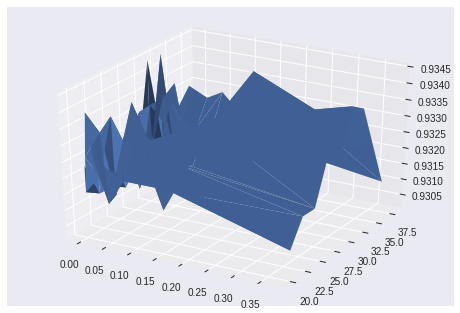

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(plot_values[:, 0], plot_values[:, 1], plot_values[:, 2], linewidth=0.2, antialiased=True)
plt.show()

**Fit the XGBoost Model with selected hyperparameters**

In [15]:
xgb = XGBOOST(min_impurity_decrease=best_log_min_impurity_decrease,M=best_M)
print('Start Training the XGB')
xgb.training(X_train,y_train)

Start Training the XGB
Adding Tree 1, the training accuracy is 0.463043
Adding Tree 2, the training accuracy is 0.997283
Adding Tree 3, the training accuracy is 0.999457
Adding Tree 4, the training accuracy is 0.999728
Adding Tree 5, the training accuracy is 0.999457
Adding Tree 6, the training accuracy is 0.999185
Adding Tree 7, the training accuracy is 0.999185
Adding Tree 8, the training accuracy is 0.999728
Adding Tree 9, the training accuracy is 0.999185
Adding Tree 10, the training accuracy is 0.999185
Adding Tree 11, the training accuracy is 0.999185
Adding Tree 12, the training accuracy is 0.999185
Adding Tree 13, the training accuracy is 0.998913
Adding Tree 14, the training accuracy is 0.999185
Adding Tree 15, the training accuracy is 0.999185
Adding Tree 16, the training accuracy is 0.999457
Adding Tree 17, the training accuracy is 0.999185
Adding Tree 18, the training accuracy is 0.999457
Adding Tree 19, the training accuracy is 0.999457
Adding Tree 20, the training accurac

0.9994565217391305

Do the testing part

In [16]:
print('Start Testing the XGB model')
xgb.testing(X_test,y_test)

Start Testing the XGB model
Adding Tree 1, the training accuracy is 0.449511
Adding Tree 2, the training accuracy is 0.917481
Adding Tree 3, the training accuracy is 0.916395
Adding Tree 4, the training accuracy is 0.926167
Adding Tree 5, the training accuracy is 0.934853
Adding Tree 6, the training accuracy is 0.935939
Adding Tree 7, the training accuracy is 0.934853
Adding Tree 8, the training accuracy is 0.935939
Adding Tree 9, the training accuracy is 0.935939
Adding Tree 10, the training accuracy is 0.935939
Adding Tree 11, the training accuracy is 0.937025
Adding Tree 12, the training accuracy is 0.937025
Adding Tree 13, the training accuracy is 0.937025
Adding Tree 14, the training accuracy is 0.937025
Adding Tree 15, the training accuracy is 0.937025
Adding Tree 16, the training accuracy is 0.937025
Adding Tree 17, the training accuracy is 0.937025
Adding Tree 18, the training accuracy is 0.937025
Adding Tree 19, the training accuracy is 0.937025
Adding Tree 20, the training ac

0.9381107491856677